In [1]:
# example.ipynb

from chemoecology_tools.core import GCMSExperiment
from chemoecology_tools.analysis import calculate_enrichment_table, perform_nmds
from chemoecology_tools.visualization import plot_nmds

In [ ]:
USER_PROVIDED_CHEMICAL_METADATA_PATH = "../example_data/user_provided_chemical_metadata.yaml"
ABUNDANCE_DATA_PATH = "../example_data/LBAL23_relative_abundance.csv"
USER_PROVIDED_SAMPLE_METADATA_PATH = "../example_data/LBAL23_metadata.yaml"
ID_COLUMN = "Bee #"

In [ ]:
# Load experimental data with metadata
experiment = GCMSExperiment.from_files(
    abundance_path=ABUNDANCE_DATA_PATH,
    metadata_path=USER_PROVIDED_SAMPLE_METADATA_PATH,
    id_col=ID_COLUMN,
    fetch_pubchem=True,
    filter_dict={
        "CHC File Located": ["NO", "Bleed"],
        "Quality": ["poor", "contaminated"],
        "Nest Code": ["E-JS-030", "E-JS-033", "E-JS-037", "E-KO-140", "E-KO-143"]
    },
    user_chemical_metadata=USER_PROVIDED_CHEMICAL_METADATA_PATH
)

Error fetching PubChem data for Unknown RI2360: 'PUGREST.ServerBusy'
Error fetching PubChem data for Eicosanolide: 'PUGREST.ServerBusy'
Error fetching PubChem data for Docosenolide: 'PUGREST.ServerBusy'
Error fetching PubChem data for Heptacosadiene: 'PUGREST.ServerBusy'
Error fetching PubChem data for Hexacosenolide: 'PUGREST.ServerBusy'


In [5]:
print(experiment)

Unnamed experiment: 84 samples, 48 chemicals measured


In [ ]:
# Filter and process data
filtered = experiment.filter_trace_compounds(threshold=0.005)
relative = filtered.calculate_relative_abundance()

# Filter by either chemical metadata OR experimental metadata
alkane_only = relative.filter({"class": "alkane"})


In [ ]:
nmds_df = perform_nmds(relative)

# Set this up to allow filtering of chemicals 

# Allow filtering of chemicals using some metadata

In [13]:
nmds_df.head()

,NMDS1,NMDS2,NMDS3,NMDS4,NMDS5,NMDS6,NMDS7,NMDS8,NMDS9,NMDS10
0,-0.002647,0.026315,-0.034789,-0.003787,-0.049289,-0.000644,0.041480,-0.015512,-0.008891,0.071178
1,-0.005356,0.040488,-0.044822,-0.033921,-0.066528,-0.042586,0.025862,-0.041505,-0.017668,0.089578
2,0.043485,0.044497,-0.065568,-0.031284,-0.081582,-0.056518,0.053002,-0.033454,-0.028388,0.133909
3,-0.045657,-0.082148,0.050189,-0.012544,-0.032394,0.059977,-0.027633,0.011787,0.061489,-0.033964
4,-0.015943,-0.004303,-0.047336,-0.051714,-0.040864,-0.038423,0.034757,0.015955,0.012079,0.088872


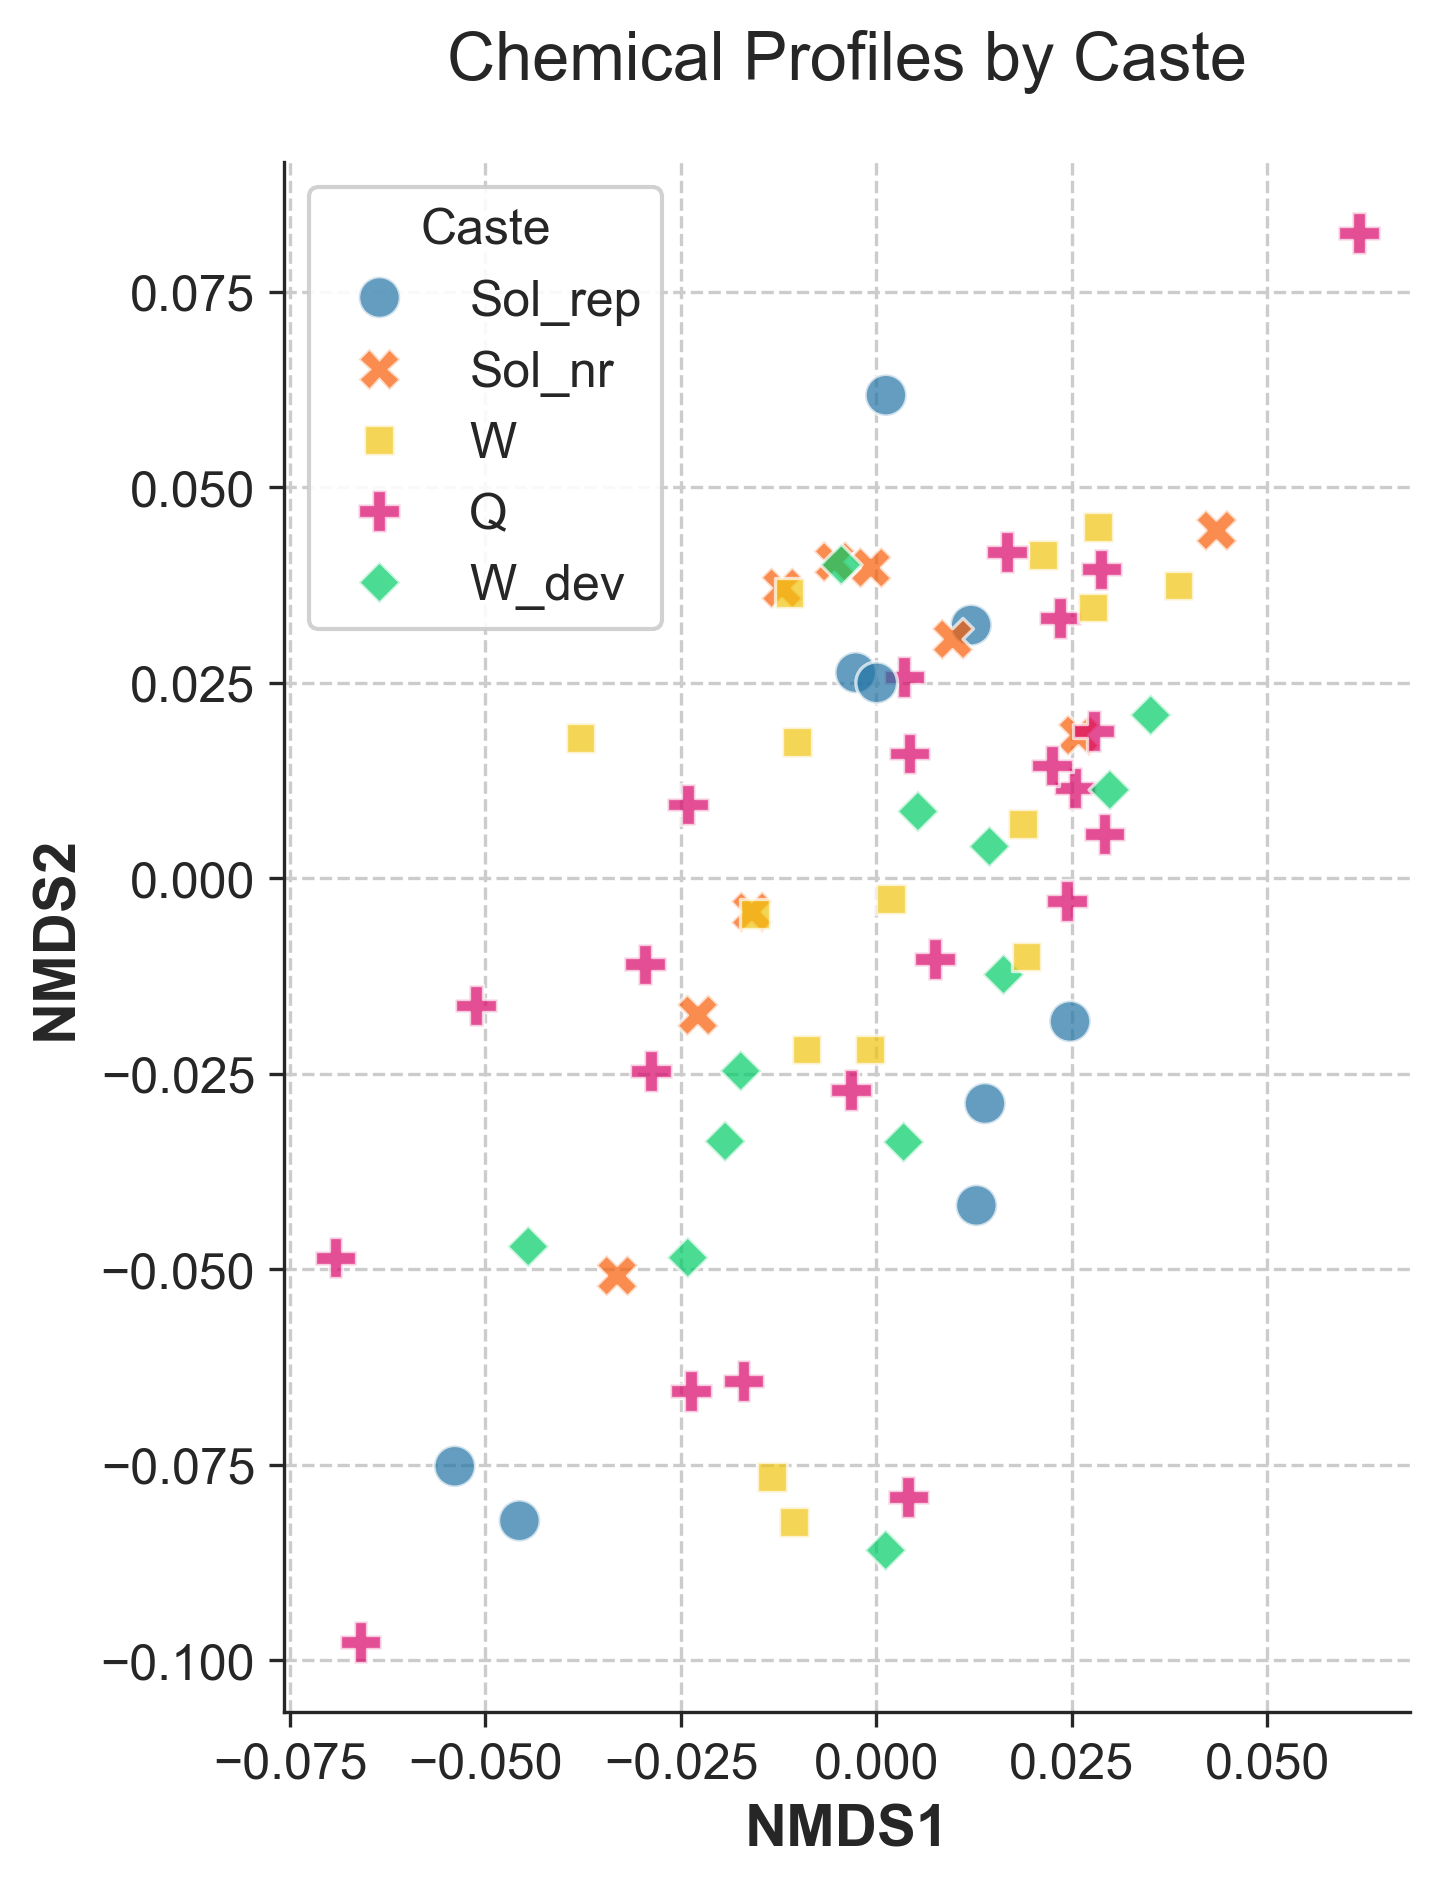

In [16]:
# Create plots with different groupings
# By caste
fig1 = plot_nmds(
    experiment=relative,
    nmds_coords=nmds_df,
    group_col="Caste",
    title="Chemical Profiles by Caste"
)

In [27]:
# Generate enrichment table
enrichment_table = calculate_enrichment_table(
    experiment=filtered,
    group_column='Caste',
    class_column='class',
    alpha=0.05
)

In [29]:
enrichment_table.to_csv("enrichment_table.csv")